In [1]:
%pip install darts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 592.0/592.0 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 KB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 KB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.

In [1]:
%pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings
warnings.filterwarnings('ignore')

from darts.models import (
    NaiveSeasonal,
    TFTModel
)
from darts.metrics import mape, mae
from pytorch_lightning.callbacks import EarlyStopping
from torchmetrics import MeanAbsolutePercentageError
from darts.utils.likelihood_models import QuantileRegression

import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.visualization import (
    plot_optimization_history,
    plot_contour,
    plot_param_importances,
)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
data = pd.read_parquet('/content/drive/MyDrive/TimeSeries/Mittelbuenden/train.parquet')
data['Date'] = pd.to_datetime(data['Date'], utc=True)
data.set_index('Date', inplace=True)
# # data = data.resample('H').sum(min_count=1)
# data = data.resample('D').sum(min_count=1)
data=data.sort_index()
data['Covid'] = 0
data.loc[(data.index >= '2020-02-01') & (data.index <= '2021-06-01'), 'Covid'] = 1
TEST_END = '2022-09-01'
TRAIN_END = '2021-09-01'
TRAIN_END = pd.to_datetime(TRAIN_END)
data = data.loc[data.index < TEST_END]
# data['TimeIndex'] = np.arange(len(data))
# data = data.drop(columns=['TimeIndex'])
data

,Consumption,Temperature,Covid
Date,,,
2018-01-01 00:00:00+00:00,437079.017331,4.191667,0
2018-01-02 00:00:00+00:00,441247.012018,2.158333,0
2018-01-03 00:00:00+00:00,428372.492620,2.604167,0
2018-01-04 00:00:00+00:00,432217.202020,1.508333,0
2018-01-05 00:00:00+00:00,410469.442938,3.991667,0
...,...,...,...
2022-08-27 00:00:00+00:00,161911.593064,18.858333,0
2022-08-28 00:00:00+00:00,149582.829196,19.729167,0
2022-08-29 00:00:00+00:00,162369.865901,20.904167,0


Data

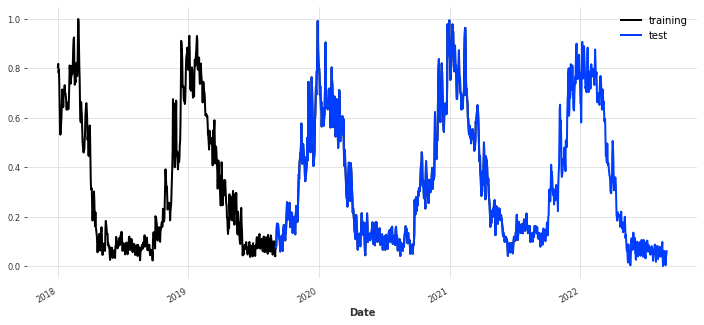

In [17]:
# from sklearn import preprocessing
# series_scaler = Scaler(scaler=preprocessing.StandardScaler())
series_scaler = Scaler()
series = TimeSeries.from_dataframe(df=data, value_cols='Consumption')
series_unsc = series
series = series_scaler.fit_transform(series)
train, test = series[0:-365], series[-365-730:]
train_unsc, test_unsc = series_unsc[0:-365], series_unsc[-365-730:]
# train, test = series.split_before(TRAIN_END)
# train_unsc, test_unsc = series_unsc.split_before(TRAIN_END)

plt.figure(101, figsize=(12, 5))
train.plot(label='training')
test.plot(label='test')
plt.legend()

Covariates

Text(0.5, 1.0, 'Covariates (Covid)')

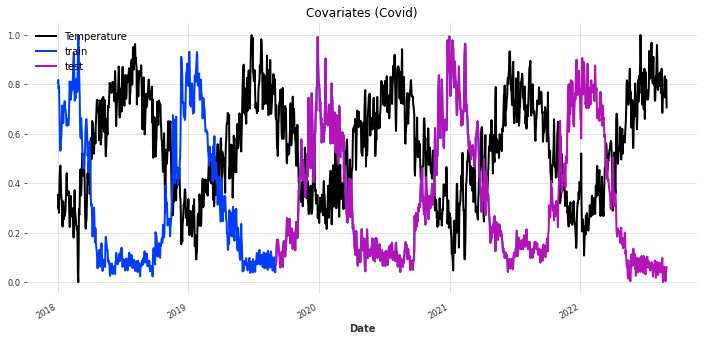

In [18]:
covid = TimeSeries.from_dataframe(df=data, value_cols='Covid')
covid = covid[1:] # it's somehow longer than the others
year = datetime_attribute_timeseries(series, attribute="year")
month = datetime_attribute_timeseries(series, attribute="month", cyclic=True)
weekday = datetime_attribute_timeseries(series, attribute="weekday", cyclic=True)
dayofyear = datetime_attribute_timeseries(series, attribute="dayofyear", cyclic=True)
temperature = TimeSeries.from_dataframe(df=data, value_cols='Temperature')
# future_scaler = Scaler(scaler=preprocessing.StandardScaler())
future_scaler = Scaler()
# past_scaler = Scaler(scaler=preprocessing.StandardScaler())
past_scaler = Scaler()


### future and past
future_covariates = temperature.stack(dayofyear).stack(year).stack(month).stack(weekday)#.stack(covid)
past_covariates = temperature
future_covariates =future_scaler.fit_transform(future_covariates)
past_covariates = past_scaler.fit_transform(past_covariates)

### future only
#future_only_covariates = year.stack(month).stack(weekday).stack(covid)
#future_only_covariates = future_only_scaler.fit_transform(future_only_covariates)

### past only
#past_only_covariates = year.stack(month).stack(weekday).stack(covid)
#past_only_covariates = past_only_scaler.fit_transform(past_only_covariates)


plt.figure(101, figsize=(12, 5))
past_covariates.plot()
train.plot(label='train')
test.plot(label='test')
plt.title("Covariates (Covid)")

TFT follow this: https://unit8co.github.io/darts/userguide/hyperparameter_optimization.html?highlight=tuning

In [ ]:
import numpy as np
import optuna
import torch
from optuna.integration import PyTorchLightningPruningCallback
from pytorch_lightning.callbacks import EarlyStopping

from darts.metrics import smape

QUANTILES = [0.01, 0.5, 0.99]
# define objective function
def objective(trial):
    lr = trial.suggest_float("lr", 5e-4, 1e-2, log=True)

    # throughout training we'll monitor the validation loss for both pruning and early stopping
    pruner = PyTorchLightningPruningCallback(trial, monitor="val_loss")
    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=3, verbose=True)
    callbacks = [early_stopper]
    pl_trainer_kwargs = {"callbacks": callbacks}

    # reproducibility
    torch.manual_seed(16)

    # model
    model = TFTModel(
        input_chunk_length=720,
        output_chunk_length=365,
        hidden_size=32, # best 5% with 128, 64 with 7.2, 32 with 7.6, 16 with 6.17, 8 with 8.2 
        hidden_continuous_size=22,
        lstm_layers=1,
        num_attention_heads=4,
        dropout=0.05,
        batch_size=32,
        optimizer_kwargs={'lr': lr},
        likelihood=QuantileRegression(quantiles=QUANTILES), 
        random_state = 16,
        pl_trainer_kwargs=pl_trainer_kwargs,
        model_name="testModel",
        force_reset=True,
        save_checkpoints=True,
      )


    model.fit(series=train,
        future_covariates=future_covariates,
        past_covariates=past_covariates,
        val_series=test,
        val_future_covariates=future_covariates,
        val_past_covariates=past_covariates,
        epochs=100,
)

    # reload best model over course of training
    model = TFTModel.load_from_checkpoint("testModel")

    # Evaluate how good it is on the validation set, using sMAPE
    preds = model.predict(n=365, future_covariates=future_covariates, past_covariates=past_covariates, num_samples=10)
    preds = series_scaler.inverse_transform(preds)
    ma = mape(test_unsc, preds)


    return ma if ma != np.nan else float("inf")


# for convenience, print some optimization trials information
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


# optimize hyperparameters by minimizing the sMAPE on the validation set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5, callbacks=[print_callback])

[I 2023-01-18 15:14:55,852] A new study created in memory with name: no-name-db787f9d-8842-45bc-8944-ea23572d983f
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vs

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.147


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.041 >= min_delta = 0.001. New best score: 0.106


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.029 >= min_delta = 0.001. New best score: 0.077


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.065


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 0.047


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.039


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.036


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.032


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.029


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.026


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 0.026. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

[I 2023-01-18 15:22:46,553] Trial 0 finished with value: 6.993158080336278 and parameters: {'lr': 0.0031903262444004823}. Best is trial 0 with value: 6.993158080336278.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _V

Current value: 6.993158080336278, Current params: {'lr': 0.0031903262444004823}
Best value: 6.993158080336278, Best params: {'lr': 0.0031903262444004823}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.089


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.001. New best score: 0.068


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.059


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.054


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.052


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.045


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.042


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.040


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.038


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.036


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.034


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.033


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 0.033. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

[I 2023-01-18 15:31:05,667] Trial 1 finished with value: 9.143606062593198 and parameters: {'lr': 0.0022611070914106118}. Best is trial 0 with value: 6.993158080336278.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _V

Current value: 9.143606062593198, Current params: {'lr': 0.0022611070914106118}
Best value: 6.993158080336278, Best params: {'lr': 0.0031903262444004823}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.097


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.001. New best score: 0.073


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.067


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.062


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.058


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.056


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.054


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.051


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.049


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.047


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.045


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.042


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.041


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.040


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 0.040. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

[I 2023-01-18 15:43:21,594] Trial 2 finished with value: 10.33904993608261 and parameters: {'lr': 0.0006811127113023703}. Best is trial 0 with value: 6.993158080336278.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _V

Current value: 10.33904993608261, Current params: {'lr': 0.0006811127113023703}
Best value: 6.993158080336278, Best params: {'lr': 0.0031903262444004823}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.112


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.040 >= min_delta = 0.001. New best score: 0.072


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.068


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.057


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.055


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.053


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.049


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.045


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.041


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.039


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.038


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 0.038. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

[I 2023-01-18 15:53:12,558] Trial 3 finished with value: 10.680390233767243 and parameters: {'lr': 0.0011740589490861874}. Best is trial 0 with value: 6.993158080336278.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _

Current value: 10.680390233767243, Current params: {'lr': 0.0011740589490861874}
Best value: 6.993158080336278, Best params: {'lr': 0.0031903262444004823}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.112


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.045 >= min_delta = 0.001. New best score: 0.067


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.064


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.063


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.054


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.049


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.047


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.044


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.042


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.040


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.037


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 0.037. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

[I 2023-01-18 16:01:49,612] Trial 4 finished with value: 10.187942564262718 and parameters: {'lr': 0.0013426592425823433}. Best is trial 0 with value: 6.993158080336278.


Current value: 10.187942564262718, Current params: {'lr': 0.0013426592425823433}
Best value: 6.993158080336278, Best params: {'lr': 0.0031903262444004823}


lstm=2, lr = 0.005
{'lr': 0.0012908197023598974, 'dropout': 0.042463807569482585, 'input_chunk_length': 14, 'hidden_size': 22, 'hidden_continuous_size': 22, lstm=2, attenuationheads=4, batchsize=32 glaub}


Full_Attenuation=True {'lr': 0.0008870003710495735, 'dropout': 0.08350420613230446, 'input_chunk_length': 27, 'hidden_size': 37, 'hidden_continuous_size': 22, 'lstm_layers': 3, 'num_attention_heads': 3, 'batch_size': 28}

Best params: {'lr': 0.001797037944322577, 'dropout': 0.05447942864290048, 'input_chunk_length': 30, 'hidden_size': 33, 'lstm_layers': 1, 'num_attention_heads': 4, 'full_attention': False}


Best value: 6.353533913311803, Best params: {'lr': 0.0062540553517696235, 'input_chunk_length': 28, 'output_chunk_length': 5, 'hidden_size': 33, 'lstm_layers': 1}


8.387096108518774, Best params: {'lr': 0.0031216319274096453}

8.163147392837153, Best params: {'lr': 0.005513572039542553} Output7

Best value: 6.951743852383069, Best params: {'lr': 0.001825327405985786} Output1